In [90]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np 
import statsmodels.api as sm
import polars_ols
from finance_byu import fama_macbeth

# Loading Data

In [91]:
bond_data = pl.read_parquet('../../data/final_data/bond_data_insample.pq')
print(bond_data.head())

shape: (5, 99)
┌─────┬────────────┬───────────┬────────────┬───┬──────────┬─────────────┬──────────────┬──────────┐
│     ┆ date       ┆ cusip     ┆ exretn_t+1 ┆ … ┆ datadate ┆ shortintadj ┆ unexpected_i ┆ oas      │
│ --- ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---      ┆ ---         ┆ nflation     ┆ ---      │
│ i64 ┆ date       ┆ str       ┆ f64        ┆   ┆ date     ┆ f64         ┆ ---          ┆ f64      │
│     ┆            ┆           ┆            ┆   ┆          ┆             ┆ f64          ┆          │
╞═════╪════════════╪═══════════╪════════════╪═══╪══════════╪═════════════╪══════════════╪══════════╡
│ 7   ┆ 2002-08-31 ┆ 00077QAG5 ┆ 0.02983    ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.013937 │
│ 11  ┆ 2002-08-31 ┆ 00104CAA6 ┆ -0.023513  ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.184844 │
│ 12  ┆ 2002-08-31 ┆ 001055AB8 ┆ 0.004369   ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.016772 │
│ 20  ┆ 2002-08-31 ┆ 00130HAQ8 ┆ -0.080008  ┆ … ┆ null     ┆ null        ┆ 0

In [92]:
bond_data = bond_data.with_columns(
    spread_duration = pl.col('oas') / pl.col('bond_yield') * pl.col('duration')
)

## Quickly filtering out bonds close to default

In [93]:
abnormal_prices = bond_data.filter(pl.col('bond_ret') >1).select('cusip').unique()
tot_cusips = bond_data.n_unique('cusip')

print(
    f'we have {len(abnormal_prices)} CUSIPs to remove, out of {tot_cusips} ({len(abnormal_prices) / tot_cusips * 100:.2f}%)')
# Segmenting in Buckets, based on Rating, Industry, Duration

we have 26 CUSIPs to remove, out of 8331 (0.31%)


In [94]:
abnormal_prices = bond_data.filter(pl.col('bondprc') < 75).select('cusip').unique()
tot_cusips = bond_data.n_unique('cusip')

print(f'we have {len(abnormal_prices)} CUSIPs to remove, out of {tot_cusips} ({len(abnormal_prices) / tot_cusips * 100:.2f}%)')
bond_data = bond_data.filter(~pl.col('cusip').is_in(abnormal_prices))

we have 1328 CUSIPs to remove, out of 8331 (15.94%)


# Segmenting in Buckets, based on Rating, Industry, Duration

## Rating

Group by rating macro-categories

In [129]:
bond_data_with_ratings = bond_data.with_columns(
    rating_bucket=pl
        .when(pl.col('rating') <= 7).then(pl.lit('A'))
        .when(pl.col('rating') <= 16).then(pl.lit('B'))
        .otherwise(pl.lit('B'))
)
bond_data = bond_data_with_ratings

## Industry

We choose the following macro-groups, based on the first digit of the SIC Code: 

- 0, 1: Agriculture, Forestry, Fishing (0) + Mining (1) + Construction (1)
- 2, 3, 5: Manufacturing (2,3), Whole Sale Trade + Retail Trade (5)
- 4, 7, 8, 9: Transportation and Public Utilities (4), Public Administration (9), Service (7, 8)
- 6: Finance, Insurance, Real Estate (6)


In [130]:
bond_data.select('PERMNO', 'sic_code').head(4)

PERMNO,sic_code
i64,i64
84766,6029
57904,6321
66413,7830
77481,4922


In [131]:
bond_data = bond_data.with_columns(
    industry_bucket=pl.col('sic_code').cast(str).str.slice(0,1).cast(int)
).with_columns(
    # assign bucket from 1 to 5 for the corresponding macro-group
    industry_bucket=pl
        .when(pl.col('industry_bucket').is_in([0,1])).then(pl.lit(1))
        .when(pl.col('industry_bucket').is_in([2,3,5])).then(pl.lit(2))
        .when(pl.col('industry_bucket').is_in([4,9])).then(pl.lit(3))
        .when(pl.col('industry_bucket') == 6).then(pl.lit(4))
        .when(pl.col('industry_bucket').is_in([7,8])).then(pl.lit(5))
)

bond_data.select('industry_bucket').head(3)

industry_bucket
i32
4
4
5


In [132]:
bond_data.select('industry_bucket').unique()

industry_bucket
i32
3
4
1
2
5


## Duration 

In [133]:
bond_data.select('duration').quantile(0.5)

duration
f64
5.402517


In [134]:
bond_data = bond_data.with_columns(
    duration_bucket=pl
        .when(pl.col('duration') <= 5.5).then(pl.lit('shortdur'))
        .otherwise(pl.lit('longdur'))
)


## Aggregate the buckets in one column

In [135]:
bond_data = bond_data.with_columns(
    bucket=(pl.col('industry_bucket').cast(str) + '_' + pl.col('rating_bucket') + '_' + pl.col('duration_bucket').cast(str))
).drop(['industry_bucket', 'rating_bucket', 'duration_bucket'])

In [136]:
bond_data.select('bucket').head(3)

bucket
str
"""4_A_shortdur"""
"""4_A_shortdur"""
"""5_B_longdur"""


In [137]:
bonds_per_date_bucket = bond_data.group_by(['date', 'bucket']).n_unique().select('date', 'bucket', 'cusip')

bonds_per_date_bucket.head()

date,bucket,cusip
date,str,u32
2013-02-28,"""5_B_longdur""",116
2003-10-31,"""3_B_longdur""",173
2005-01-31,"""2_A_longdur""",208
2006-02-28,"""4_B_shortdur""",77
2009-06-30,"""2_A_shortdur""",200


In [138]:
bonds_per_date_bucket.filter(pl.col('cusip') < 10).shape[0] / bonds_per_date_bucket.shape[0]

0.07106769956214214

# Compute Residual Returns

In [139]:
def weighted_median_pl(data: pl.type_aliases.Sequence[pl.Series]):
    """Compute weighted median of observations with Polars

    To be used inside map_groups, to which you specify as expressions first the values, then the weights to use.
    The function takes two pl.Series: the first is the values to use, the second is the weights. 
    The function returns the weighted median for the given group of observations
    """
    values, weights = data
    values = values.to_numpy()
    weights = weights.to_numpy()
    i = np.argsort(values) 
    c = np.cumsum(weights[i])

    weighted_median = values[i[np.searchsorted(c, 0.5 * c[-1])]]
    return weighted_median


In [140]:
def compute_residual_returns(df: pl.DataFrame, oas_column: str = 'oas', use_median: bool = False):
    """Compute Residual return as unadjusted return - systematic return.
    
    * dxs = Duration * Spread
    * Systematic Return = Relative DTS * Weighted average return of bond's bucket
    * Relative dxs = Bond DTS / weighted average DTS of bond bucket
    
    * Residual return = bond_ret_t+1 - Systematic Return
    
    """
    df = df.with_columns(
        dxs = pl.col('spread_duration') * pl.col(oas_column)
    )
    
    grouped = df.select('bucket', 'dxs', 'exretnc_dur_t+1', 'bond_amount_out').drop_nulls().group_by('bucket')
    
    if use_median: 
        weighted_dxs = grouped.agg(
            weighted_dxs_median=pl.map_groups(exprs=['dxs', 'bond_amount_out'], function=weighted_median_pl),
            weighted_ret_median=pl.map_groups(exprs=['exretnc_dur_t+1', 'bond_amount_out'], function=weighted_median_pl)
        )
    else: 
        weighted_dxs = grouped.agg(
            weighted_dxs_mean=(pl.col('dxs').dot(pl.col('bond_amount_out')) / pl.sum('bond_amount_out')),
            weighted_ret_mean=(pl.col('exretnc_dur_t+1').dot(pl.col('bond_amount_out')) / pl.sum('bond_amount_out')),
        )
        
    dxs_col = 'weighted_dxs_' + ('median' if use_median else 'mean')
    ret_col = 'weighted_ret_' + ('median' if use_median else 'mean')
    
    df = (df.select(pl.all().exclude(dxs_col, ret_col))
        .join(weighted_dxs, how='left', on='bucket')
        .with_columns(
            relative_dxs = pl.col('dxs') / pl.col(dxs_col)
        ).with_columns(
            systematic_return = pl.col('relative_dxs') * pl.col(ret_col)
        ).with_columns(
            (pl.col('bond_ret_t+1') - pl.col('systematic_return')).alias('residual_return_t+1'),
        ))
    
    return df

In [141]:
bond_data = compute_residual_returns(bond_data, use_median=True, oas_column='oas')

In [142]:
bond_data.filter(pl.col('bond_ret_t+1') > 0.5)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,COUPAMT,COUPACC,MULTICOUPS,RET_EOM,RET_LDM,RET_L5M,REMCOUPS,DURATION_right,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,i64,str,str,str,i64,f64,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64,f64,f64


In [143]:
bond_data.select('residual_return_t+1').describe()

statistic,residual_return_t+1
str,f64
"""count""",312455.0
"""null_count""",68888.0
"""mean""",0.003027
"""std""",0.023881
"""min""",-0.806988
"""25%""",-0.006188
"""50%""",0.002719
"""75%""",0.012632
"""max""",0.446559


# Scoring Signals based on the quantile 

## Shared Functions

In [144]:
def compute_quantiles(df: pl.DataFrame, col: str, n_quantiles: int):
    """Divide the cols in quantiles based on the bucket groups"""
    quantile_col_name = f'{col}_quantile'
    delta_col_name = f'{col}_bucket_delta'
    mean_col_name = f'{col}_bucket_mean'
    
    # create the bins and labels to be used in qcut
    bins = np.linspace(0,1,n_quantiles+1)[1:]
    labels = [str(i+1) for i in range(n_quantiles+1)]
    
    # compute the mean of the signal for each bucket at each date
    col_mean_by_bucket = df.select('date', 'bucket', col).group_by(['date', 'bucket']).agg(
        pl.col(col).drop_nans().mean().alias(mean_col_name) # .mean breaks with NaNs, so drop them 
    )
    
    # join the dataframes and compute the difference with respect to the group average (computed before)
    deltas = (df
              .select(pl.all().exclude(quantile_col_name, mean_col_name))
              .join(col_mean_by_bucket, how='left', on=['date', 'bucket'])
              .with_columns(
                    (pl.col(col) - pl.col(mean_col_name)).alias(delta_col_name)
                )           
              )
    # just select the cols we need, to make computations faster
    deltas = deltas.select('date', 'cusip', 'bucket', delta_col_name)

    data = []
    total_items = col_mean_by_bucket.shape[0]
    print('computing... ', end='')

    i = 0
    for group in col_mean_by_bucket.iter_rows(named=True):
        i += 1
        
        # filter for NaNs and Nulls as well 
        mask = (pl.col('date') == group['date']) & (pl.col('bucket') == group['bucket']) & (pl.col(delta_col_name).is_not_nan() & (pl.col(delta_col_name).is_not_null()))
        
        group_data = deltas.filter(mask)
        # if the DataFrame is emtpy just continue, otherwise qcut will throw an error
        if group_data.shape[0] == 0:
            continue
        
        group_data = group_data.with_columns(
            pl.col(delta_col_name).qcut(bins,labels=labels, allow_duplicates=True).alias(quantile_col_name)
        )
            
        data.append(group_data)
        
        if i % 1000 == 0: 
            print(f'{i}/{total_items} ', end='')
    
    print('... done!')
    
    quantiles = pl.concat(data, how='vertical')
    quantiles = quantiles.with_columns(
        pl.col(quantile_col_name).cast(int).alias(quantile_col_name)
    )
    return df.join(quantiles.drop('bucket'), how='left', on=['date', 'cusip'])

In [145]:
def compute_information_ratio(
        df_with_quantiles: pl.DataFrame, 
        quantile_col: str, 
        return_col: str = 'residual_return_t+1', 
): 
    # group returns by date and the quantile, and compute the average return of the portfolio at the end of every month
    signal_monthly_returns = df_with_quantiles.group_by(['date', quantile_col]).agg(
        pl.col(return_col).drop_nans().mean().alias('mean_return'), # mean return of the portfolio at EoM
    ).filter(pl.col(quantile_col).is_not_null())
    
    signal_monthly_returns = signal_monthly_returns.sort(['date', quantile_col])
    
    long_short_returns = signal_monthly_returns.pivot(index='date', columns=quantile_col, values='mean_return').with_columns(
        (pl.col('10')-pl.col('1')).alias('long_short')
    ).select('date', 'long_short')
    market_returns = df_with_quantiles.group_by('date').agg(pl.col(return_col).mean().alias('mkt_return'))
    
    portfolio_returns = long_short_returns.join(market_returns, how='left', on='date').with_columns(
        delta=(pl.col('long_short')-pl.col('mkt_return'))
    )
    
    information_ratio = portfolio_returns['delta'].mean() / portfolio_returns['delta'].std()
    
    return information_ratio * np.sqrt(12)

In [160]:
from skmisc.loess import loess

def get_expected_alpha(
        df_with_quantiles: pl.DataFrame, 
        quantile_col: str,  
        plot: bool = False,
        interpolate: bool = False,
): 
    return_col = 'residual_return_t+1'
    
    # group returns by date and the quantile, and compute the average return of the portfolio at the end of every month
    monthly_returns_by_bucket = df_with_quantiles.group_by(['date', quantile_col]).agg(
        pl.col(return_col).drop_nans().mean().alias('mean_return'), # mean return of the portfolio at EoM
    )
    
    final_portfolio_returns = monthly_returns_by_bucket.group_by(quantile_col).agg(
        pl.col('mean_return').mean().alias('avg_monthly_return'),
        pl.col('mean_return').std().alias('monthly_stdev'),
        ((pl.col('mean_return').mean() / pl.col('mean_return').std()) * np.sqrt(12)).alias('sharpe_ratio'),
    )
    
    # insert the key to sort by
    final_portfolio_returns = final_portfolio_returns.sort(by=quantile_col).drop_nulls()
    
    spline_loess = None
    if plot: 
        fig, axs = plt.subplots(1,2, figsize=(12,6))
        
        ax1, ax2 = axs
        
        alpha = 0.3 if interpolate else 1
        ax1.bar(x=final_portfolio_returns[quantile_col], height=final_portfolio_returns['avg_monthly_return'])
        ax12 = ax1.twinx()
        ax12.scatter(x=final_portfolio_returns[quantile_col], y=final_portfolio_returns['monthly_stdev'], label='Volatility')
        # ax12.scatter(x=final_portfolio_returns[quantile_col], y=final_portfolio_returns['sharpe_ratio'], label='Sharpe Ratio')
        ax1.legend()
        
        ax2.axhline(color='black')
     
        data = final_portfolio_returns.select(quantile_col, 'avg_monthly_return').to_numpy()
        x, y = data[:, 0], data[:, 1]
        
        spline_loess = loess(x,y, surface='direct')
        spline_loess.fit()
        
        x_new = np.linspace(x[0], x[-1], 100)
        pred = spline_loess.predict(x_new, stderror=True)
        conf = pred.confidence()
        
        lowess_vals = pred.values
        ll = conf.lower
        ul = conf.upper
        
        x_new = np.linspace(x[0], x[-1], 100)
    
        ax2.fill_between(x_new,ll,ul,alpha=0.5)
        ax2.scatter(x=final_portfolio_returns[quantile_col], y=final_portfolio_returns['avg_monthly_return'], label='Expected Alpha')
        ax2.plot(x_new, lowess_vals)

    return final_portfolio_returns, spline_loess

In [200]:
def map_quantile_to_alpha_est(spline: loess):
    """Wrapper that Returns the function to throw in map_batches, given the correct spline for the signal"""
    def f(x: pl.Series): 
        data = x.to_numpy()
        n = len(data)
        
        values = np.zeros(n)
        values[:] = np.nan
        
        for i in range(n):
            val = data[i]
            if np.isnan(val):
                continue
            signal_val = spline.predict([val]).values
            values[i] = signal_val[0]
            
        return values
    
    return f 

def quantile_to_alpha_est(df: pl.DataFrame, quantile_col: str, new_col_name: str, spline: loess): 
    df = df.with_columns(
        pl.col(quantile_col).map_batches(function=map_quantile_to_alpha_est(spline), return_dtype=pl.Float64).fill_nan(None).alias(new_col_name),
    ).with_columns(
        ((pl.col(new_col_name) - pl.col(new_col_name).drop_nulls().mean()) / pl.col(new_col_name).drop_nulls().std()).alias(new_col_name)
    )
    
    return df 

In [147]:
def _update_transition_prob_matrix(chain, counts_matrix, lag):
    flat_coords = np.ravel_multi_index((chain[:-lag], chain[lag:]), counts_matrix.shape)
    return np.bincount(flat_coords, minlength=counts_matrix.size).reshape(counts_matrix.shape)

def _convert_to_probabilities(transition_matrix: np.ndarray): 
    M = transition_matrix.copy()
    for row in M: 
        n = sum(row)
        if n > 0: 
            row[:] = [f/n for f in row] 
    
    return M

def compute_transition_matrix(df_with_quantiles: pl.DataFrame, quantile_col: str, n_quantiles: int, lag: int = 1, plot: bool = False):
    """Compute the transition probabilities for quantiles for a given signal, given a certain lag (1 unit of lag is 1 month of time)"""
    
    # group by the cusip, and get the evolution of the quantile during time for each bond
    quantiles_evolution = df_with_quantiles.sort('date').filter(pl.col(quantile_col).is_not_null()).group_by('cusip', maintain_order=True).agg(pl.col(quantile_col))
    
    # initialize the matrix of transition probabilities
    transition_probabilities = np.zeros((n_quantiles, n_quantiles), dtype=np.float64)
    
    # iterate through the different evolutions and update the transition probabilities
    for row in quantiles_evolution.iter_rows(): 
        chain = row[1]
        if np.min(chain) != 0: 
            chain -= np.min(chain)
        
        transition_probabilities[:, :] += _update_transition_prob_matrix(chain, transition_probabilities, lag)
    
    # convert these to actual probabilities
    transition_probabilities = _convert_to_probabilities(transition_probabilities)
    
    if plot: 
        fig, ax = plt.subplots()
        ax.imshow(transition_probabilities, cmap='hot', interpolation='nearest')
    
    return transition_probabilities

## Carry

For carry, we rank each bond based on its OAS. 

In [148]:
bond_data_oas_quantiles = compute_quantiles(bond_data, 'oas', 10) 

computing... 1000/2969 2000/2969 ... done!


In [149]:
bond_data = bond_data_oas_quantiles

In [150]:
compute_information_ratio(bond_data, 'oas_quantile')

0.8913875244665506

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


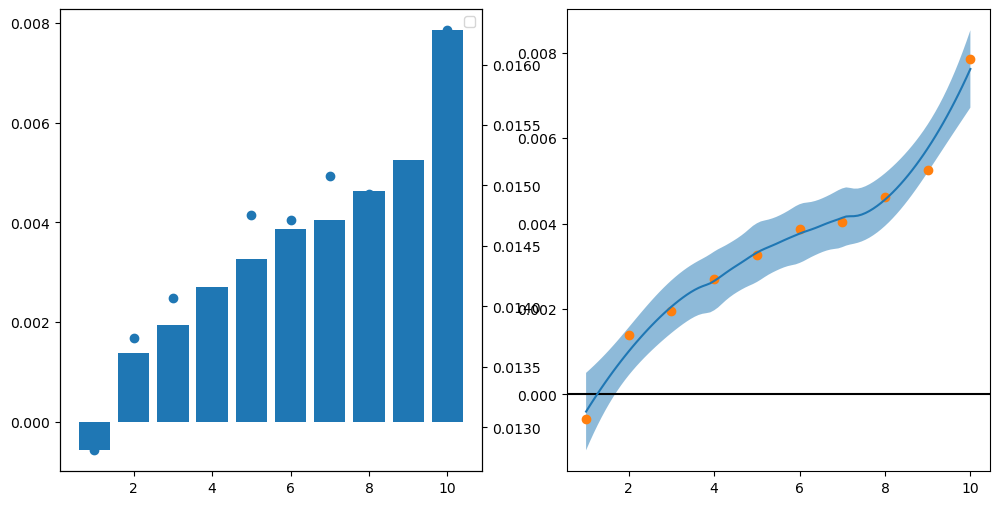

In [161]:
carry_returns, carry_spline = get_expected_alpha(bond_data, 'oas_quantile', plot=True, interpolate=True)

In [199]:
bond_data = quantile_to_alpha_est(bond_data, 'oas_quantile', 'carry_signal_value', carry_spline)
bond_data.select('carry_signal_value')

carry_signal_value
f64
-0.056882
0.313199
1.89192
null
1.049597
…
0.313199
0.145291
-0.629587


array([[62., 22.,  7.,  3.,  2.,  1.,  1.,  1.,  0.,  0.],
       [20., 49., 19.,  6.,  3.,  1.,  1.,  1.,  0.,  0.],
       [ 7., 21., 43., 18.,  6.,  2.,  1.,  1.,  1.,  0.],
       [ 4.,  8., 21., 38., 18.,  6.,  3.,  1.,  1.,  0.],
       [ 2.,  4.,  9., 21., 37., 16.,  6.,  2.,  1.,  1.],
       [ 2.,  3.,  4.,  9., 22., 36., 16.,  5.,  2.,  1.],
       [ 2.,  2.,  3.,  5., 10., 20., 36., 16.,  5.,  2.],
       [ 2.,  2.,  2.,  3.,  5.,  9., 21., 38., 14.,  4.],
       [ 2.,  1.,  2.,  2.,  3.,  5., 10., 21., 40., 13.],
       [ 2.,  2.,  2.,  3.,  3.,  4.,  6.,  9., 20., 49.]])

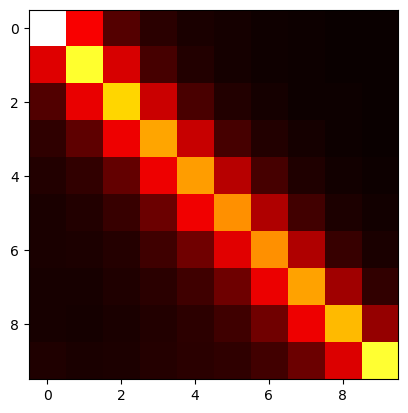

In [35]:
transition_probs = compute_transition_matrix(bond_data, 'oas_quantile', 10, lag=1, plot=True)
np.round(transition_probs, 2) * 100

## Momentum (Excess Credit Return)

We use the **Credit Excess Return**, as defined by the AQR paper, to define momentum.

$$
CER_t=\frac{1}{12}Spread_{t-1}-\text{Spread Duration}_{t-1}\times(Spread_t-Spread_{t-1})
$$

Which translated to our data is

$$
CER_t=\frac{1}{12}OAS_{t-1}-\text{duration}_{t-1}\times(OAS_t-OAS_{t-1})
$$


In [204]:
bond_data.select('YIELD', 'bond_yield').null_count()

YIELD,bond_yield
u32,u32
2329,2329


In [205]:
# compute excess credit return at each timestamp
bond_data = bond_data.sort(['cusip', 'date'])
bond_data = bond_data.with_columns(
    excess_credit_ret=(pl.col('oas').shift(1) / 12 - pl.col('spread_duration') * (pl.col('oas') - pl.col('oas').shift(1)))
)

mask = pl.col('cusip') != pl.col('cusip').shift(1)

bond_data = bond_data.with_columns(
    excess_credit_ret=pl.when(mask).then(np.nan).otherwise(pl.col('excess_credit_ret'))
)

In [206]:
# compute the x_month rolling excess return
def momentum(df: pl.DataFrame, period: str, min_periods: int, n_months: int):
    momentum_returns = df.sort(['cusip', 'date']).rolling('date', group_by='cusip', period=period).agg(
        pl.when(pl.col('excess_credit_ret').len() > min_periods).then(pl.col('excess_credit_ret').add(1).product().sub(1)).otherwise(np.nan).alias(f'mom_{n_months}mo'),
        pl.when(pl.col('excess_credit_ret').len() > min_periods).then(pl.col('bondprc').last() / pl.col('bondprc').first() - 1).otherwise(np.nan).alias(f'price_mom_{n_months}mo'),
    )
    return momentum_returns


mom_6mo = momentum(bond_data, '5mo20d', 5, 6)
mom_12mo = momentum(bond_data, '11mo20d', 9, 12)

bond_data = bond_data.join(
    mom_6mo,
    how='left',
    on=['cusip', 'date'],
).join(
    mom_12mo,
    how='left',
    on=['cusip', 'date'],
)

In [207]:
bond_data = compute_quantiles(bond_data, 'price_mom_6mo', 10)
bond_data = compute_quantiles(bond_data, 'price_mom_12mo', 10)

computing... 1000/2969 2000/2969 ... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


computing... 1000/2969 2000/2969 ... done!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


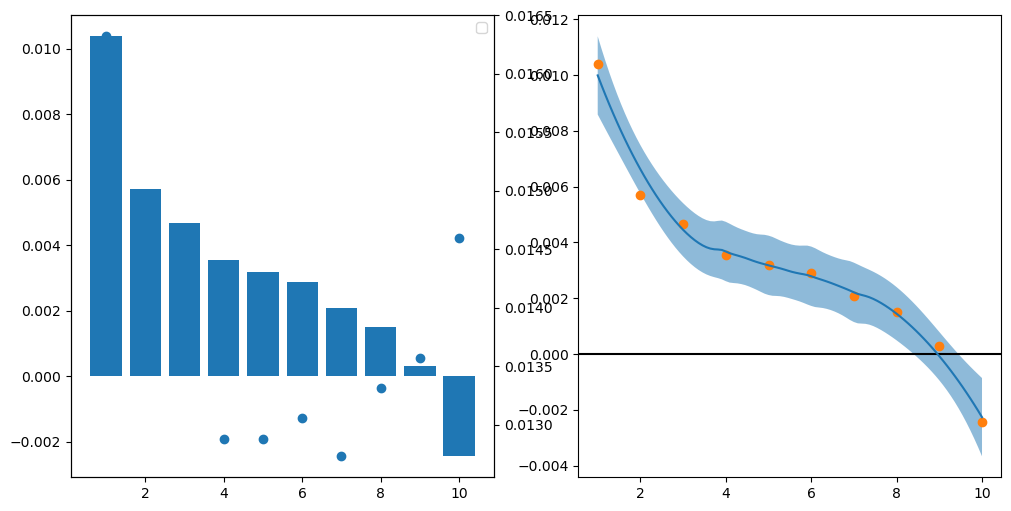

In [209]:
credit_mom_returns, credit_mom_spline = get_expected_alpha(bond_data, 'price_mom_6mo_quantile', plot=True, interpolate=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


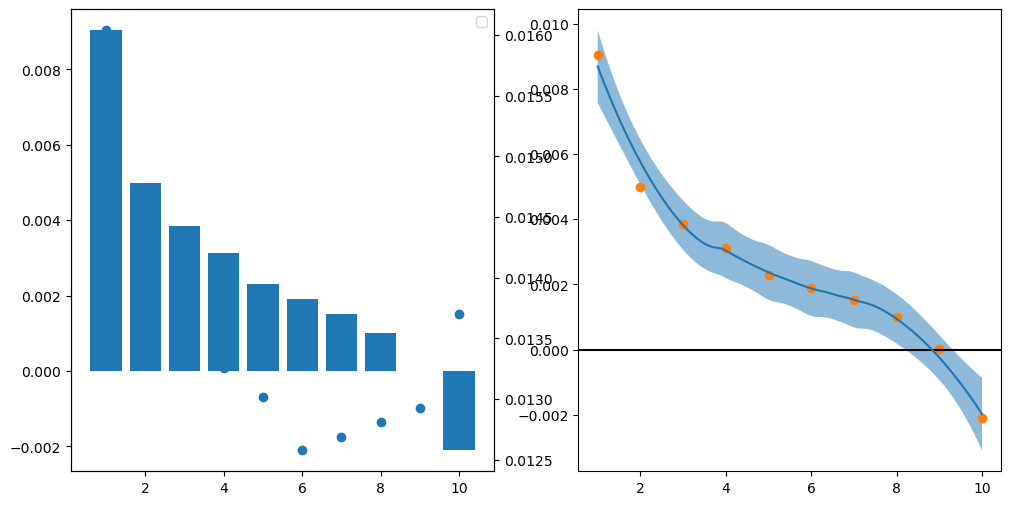

In [213]:
credit_mom_12mo_returns, credit_mom_12mo_spline = get_expected_alpha(bond_data, 'price_mom_12mo_quantile', plot=True, interpolate=True)

In [214]:
bond_data = quantile_to_alpha_est(bond_data, 'price_mom_12mo_quantile', 'credit_mom_signal_value', credit_mom_12mo_spline)

array([[0.37104215, 0.1911774 , 0.11211528, 0.07950452, 0.0589964 ,
        0.04458699, 0.03782469, 0.03485433, 0.03144157, 0.03845668],
       [0.20764466, 0.21760257, 0.1663758 , 0.11682579, 0.08216131,
        0.05834445, 0.04688088, 0.03798378, 0.0327824 , 0.03339835],
       [0.12672621, 0.16970113, 0.18182755, 0.14953624, 0.1147372 ,
        0.07959464, 0.06015115, 0.04699416, 0.03912745, 0.03160426],
       [0.09240489, 0.12548598, 0.15412385, 0.16301027, 0.14360594,
        0.10854624, 0.07872813, 0.05567898, 0.043599  , 0.03481672],
       [0.07134646, 0.0876154 , 0.11924752, 0.14791848, 0.16108692,
        0.13788539, 0.1031876 , 0.07552691, 0.05458979, 0.04159554],
       [0.05488406, 0.06474347, 0.09048749, 0.11677926, 0.14573672,
        0.16118313, 0.1369728 , 0.10498448, 0.07317875, 0.05104984],
       [0.04714987, 0.05171763, 0.07119668, 0.09067573, 0.1198943 ,
        0.14435636, 0.16553416, 0.14065685, 0.09996225, 0.06885617],
       [0.04110504, 0.04648878, 0.0523440

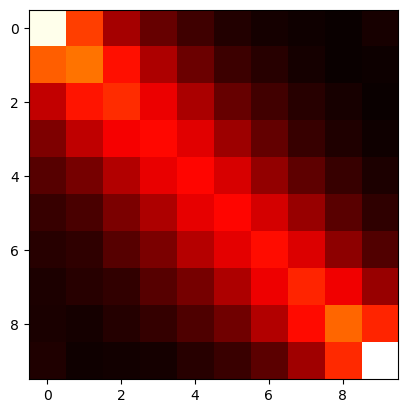

In [43]:
compute_transition_matrix(bond_data, 'price_mom_6mo_quantile', 10, lag=1, plot=True)

array([[0.48065697, 0.2030276 , 0.10461396, 0.06434484, 0.04442466,
        0.02895683, 0.02542792, 0.0177105 , 0.0148412 , 0.01599551],
       [0.22638465, 0.28871584, 0.18194254, 0.10719422, 0.06440072,
        0.04479287, 0.03132344, 0.02329089, 0.01760847, 0.01434635],
       [0.11623944, 0.1981467 , 0.23631329, 0.168217  , 0.10679543,
        0.06280622, 0.04327913, 0.03191792, 0.02137329, 0.0149116 ],
       [0.07188602, 0.11444916, 0.18626322, 0.21501043, 0.16043031,
        0.10318774, 0.06163201, 0.03997266, 0.02684033, 0.02032813],
       [0.0494675 , 0.07399927, 0.11939038, 0.17455013, 0.21024605,
        0.1526625 , 0.09614396, 0.06088873, 0.03712817, 0.02552332],
       [0.03716163, 0.04915308, 0.07321513, 0.12197246, 0.17456862,
        0.20452747, 0.15398924, 0.0966044 , 0.05611841, 0.03268957],
       [0.02861565, 0.0368573 , 0.05158348, 0.0760574 , 0.12220223,
        0.17018784, 0.21022466, 0.15692591, 0.09446513, 0.05288039],
       [0.02356753, 0.02898229, 0.0375038

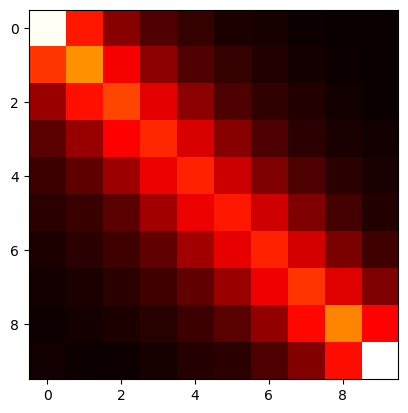

In [215]:
compute_transition_matrix(bond_data, 'price_mom_12mo_quantile', 10, lag=1, plot=True)

## Value

We use **Excess Spread to Peers** as a Value Signal in our strategy.

In [216]:
oas_bucket_means = bond_data.group_by(['date', 'bucket']).agg(pl.col('oas').drop_nans().mean().alias('ESP_bucket_mean_oas'))

In [217]:
oas_bucket_means

date,bucket,ESP_bucket_mean_oas
date,str,f64
2012-06-30,"""2_B_longdur""",0.030765
2006-03-31,"""5_A_shortdur""",0.007979
2004-08-31,"""1_A_shortdur""",null
2007-04-30,"""1_A_longdur""",0.012128
2012-04-30,"""4_B_shortdur""",0.029089
…,…,…
2003-12-31,"""2_A_shortdur""",0.006589
2003-06-30,"""2_B_longdur""",0.022774
2007-10-31,"""3_B_longdur""",0.016768


In [218]:
bond_data = bond_data.join(oas_bucket_means, on=['date', 'bucket'], how='left')

In [219]:
bond_data = bond_data.with_columns( 
    ESP = pl.col('oas') - pl.col('ESP_bucket_mean_oas'))

In [220]:
bond_data.select('de_ratio', 'intcov_ratio', 'debt_ebitda').null_count()

de_ratio,intcov_ratio,debt_ebitda
u32,u32,u32
70090,92830,71128


In [221]:
bond_data.head(3)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median,oas_bucket_delta_right,oas_quantile_right,carry_signal_val,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,credit_mom_signal_value,ESP_bucket_mean_oas,ESP
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,4.676272,0.003748,0.002438,0.001853,8,0.005916,0.000801,0.001853,8,0.505634,0.505634,null,NaN,NaN,NaN,NaN,null,null,null,null,null,0.008071,0.001853
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,3.207915,0.002571,0.009157,0.000939,7,0.005916,0.000801,0.000939,7,0.313199,0.313199,0.005302,NaN,NaN,NaN,NaN,null,null,null,null,null,0.007091,0.000939
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,2.882135,0.00231,-0.003401,0.000514,7,0.005916,0.000801,0.000514,7,0.313199,0.313199,0.00289,NaN,NaN,NaN,NaN,null,null,null,null,null,0.006591,0.000514


In [222]:
col = 'ESP'
bond_data.filter(pl.col(col).is_nan()).shape

(37679, 125)

In [223]:
bond_data.select('ESP').null_count()

ESP
u32
6


In [224]:
bond_data = bond_data.with_columns(
    ESP=pl.col('ESP').fill_nan(None)
)

In [225]:
bond_data.select('ESP', 'debt_ebitda', 'de_ratio', 'intcov_ratio').dtypes

[Float64, Float64, Float64, Float64]

In [226]:
bond_data.select('ESP').null_count()

ESP
u32
37685


In [227]:
bond_data_with_residuals = bond_data.with_columns(
    esp_residual = pl
        .col('ESP')
        .least_squares
        .ols(pl.col("debt_ebitda"), pl.col("intcov_ratio"), pl.col("de_ratio"), add_intercept=True, mode="residuals", null_policy='drop', solve_method='svd')
        .over(['date', 'bucket'])
)

In [228]:
bond_data_with_residuals.filter((pl.col('esp_residual').is_not_null()) & (pl.col('esp_residual').is_not_nan())).head(2)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median,oas_bucket_delta_right,oas_quantile_right,carry_signal_val,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,credit_mom_signal_value,ESP_bucket_mean_oas,ESP,esp_residual
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64
655893,2013-06-30,"""00081TAH1""",0.018735,0.017647,0.016228,0.018735,null,null,null,14.0,0.051247,null,0.066372,500000.0,500000.0,100.608587,1.006086,83.2,5.483466,11.0,3579,-0.035034,-0.364294,null,3.0,1.0,1.0,0.067015,0.052294,100.25,101.393751,35.286382,null,5.0304294e7,5.0125e7,6.75,…,0.643,4.519,2.931,2.835,0.237,-0.110489,2013-06-01,1.7355712e7,0.001502,0.048318,3.991868,"""2_B_shortdur""",0.192879,6.208521,0.012798,0.005937,0.019104,8,0.031067,0.002061,0.019104,8,0.505634,0.505634,NaN,NaN,NaN,NaN,NaN,null,null,null,null,null,0.029214,0.019104,0.01336
661683,2013-07-31,"""00081TAH1""",-0.018059,-0.005246,-0.008077,-0.018059,0.018735,0.018735,0.016228,14.0,0.049002,null,0.063966,500000.0,500000.0,101.924342,1.019243,82.166667,5.4174,11.0,3579,0.029584,-0.104662,null,12.0,1.0,1.0,0.061464,0.046607,103.2812,104.987454,34.767405,null,5.0962171e7,5.16406e7,6.75,…,0.643,4.519,2.931,2.835,0.237,0.039309,2013-07-01,1.8036752e7,0.005199,0.045777,3.876904,"""2_B_shortdur""",0.177472,5.712591,0.011775,-0.029835,0.018052,8,0.031067,0.002061,0.018052,8,0.505634,0.505634,0.013879,NaN,NaN,NaN,NaN,null,null,null,null,null,0.027725,0.018052,0.013278


In [229]:
bond_data_with_residuals.filter((pl.col('esp_residual').is_not_null()) & (pl.col('esp_residual').is_not_nan())).shape

(259738, 126)

In [230]:
bond_data = bond_data_with_residuals

In [231]:
bond_data = compute_quantiles(bond_data, 'esp_residual', 10) 

computing... 1000/2969 2000/2969 ... done!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


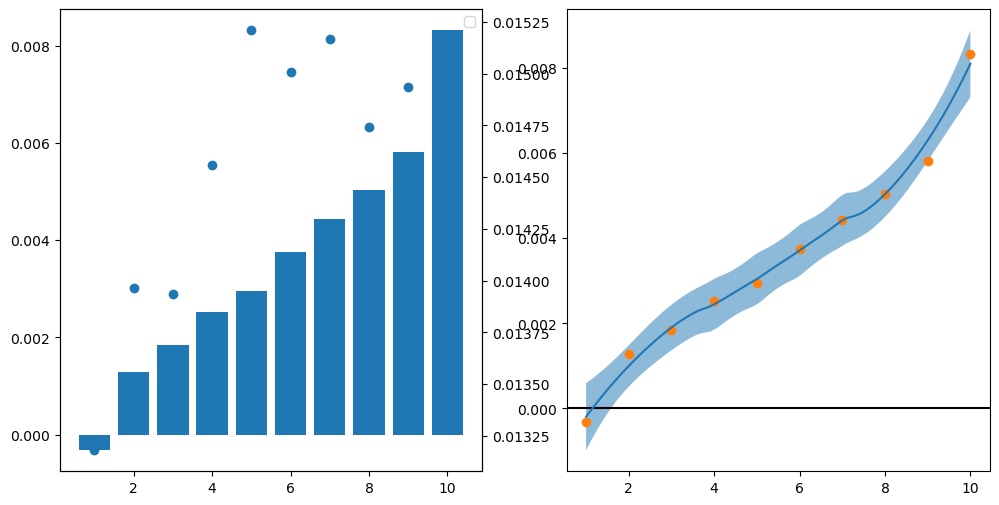

In [232]:
esp_returns, esp_spline = get_expected_alpha(bond_data, 'esp_residual_quantile', plot=True, interpolate=True)

In [234]:
bond_data = quantile_to_alpha_est(bond_data, 'esp_residual_quantile', 'esp_signal_value', esp_spline)

## Quality

We use Interest Coverage Ratio as a Quality Signal in our strategy. We end up excluding this as no significant information can be gained by including it

In [235]:
intcov_quantiles = compute_quantiles(bond_data, 'debt_ebitda', 5) 

computing... 1000/2969 2000/2969 ... done!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: b'There are other near singularities as well. 1'

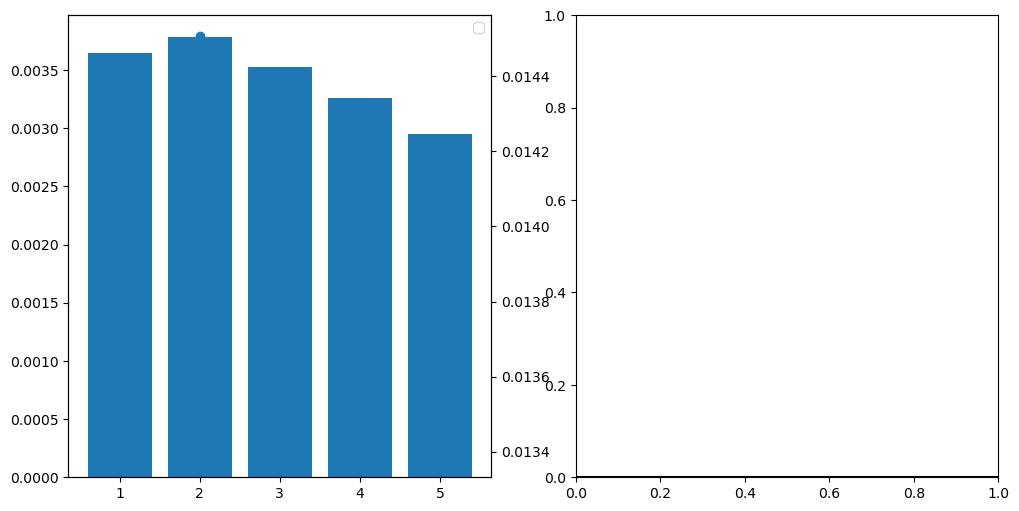

In [236]:
get_expected_alpha(intcov_quantiles, 'debt_ebitda_quantile', plot=True, interpolate=True)

In [65]:
intcov_quantiles

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_quantile,esp_residual_bucket_delta,debt_ebitda_bucket_delta,debt_ebitda_quantile
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,i64,f64,f64,i64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_1""",0.027666,0.005916,0.000801,4.676272,0.003748,0.002438,0.001853,8,null,NaN,NaN,NaN,NaN,null,null,null,null,0.008071,0.001853,null,null,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_1""",0.018979,0.005916,0.000801,3.207915,0.002571,0.009157,0.000939,7,0.005302,NaN,NaN,NaN,NaN,null,null,null,null,0.007091,0.000939,null,null,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_1""",0.017051,0.005916,0.000801,2.882135,0.00231,-0.003401,0.000514,7,0.00289,NaN,NaN,NaN,NaN,null,null,null,null,0.006591,0.000514,null,null,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,null,null,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_1""",0.017731,0.005916,0.000801,2.996963,0.002402,-0.000117,0.000918,7,-0.000224,NaN,NaN,NaN,NaN,null,null,null,null,0.006529,0.000918,null,null,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,null,null,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_1""",0.014568,0.005916,0.000801,2.462358,0.001973,0.00001,0.001135,7,0.002127,NaN,NaN,NaN,NaN,null,null,null,null,0.005614,0.001135,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

## Equity Momentum in Credit

In [237]:
def equity_momentum(df: pl.DataFrame, period: str, min_periods: int, n_months: int):
    eq_momentum_returns = df.sort(['cusip', 'date']).rolling('date', group_by='cusip', period=period).agg(
        pl.when(pl.col('equity_month_return').len() > min_periods).then(pl.col('equity_month_return').add(1).product().sub(1)).otherwise(np.nan).alias(f'eq_mom_{n_months}mo'),
        )
    return eq_momentum_returns

eq_mom_6mo = equity_momentum(bond_data, '5mo20d', 5, 6)
eq_mom_12mo = equity_momentum(bond_data, '11mo20d', 9, 12)

bond_data = bond_data.join(
    eq_mom_6mo,
    how='left',
    on=['cusip', 'date'],
).join(
    eq_mom_12mo,
    how='left',
    on=['cusip', 'date'],
)

In [238]:
bond_data.head(2)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median,oas_bucket_delta_right,oas_quantile_right,carry_signal_val,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,credit_mom_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_bucket_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,4.676272,0.003748,0.002438,0.001853,8,0.005916,0.000801,0.001853,8,0.505634,0.505634,null,NaN,NaN,NaN,NaN,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,3.207915,0.002571,0.009157,0.000939,7,0.005916,0.000801,0.000939,7,0.313199,0.313199,0.005302,NaN,NaN,NaN,NaN,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN


In [239]:
bond_data = compute_quantiles(bond_data, 'eq_mom_6mo', 10)
bond_data = compute_quantiles(bond_data, 'eq_mom_12mo', 10)

computing... 1000/2969 2000/2969 ... done!
computing... 1000/2969 2000/2969 ... done!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


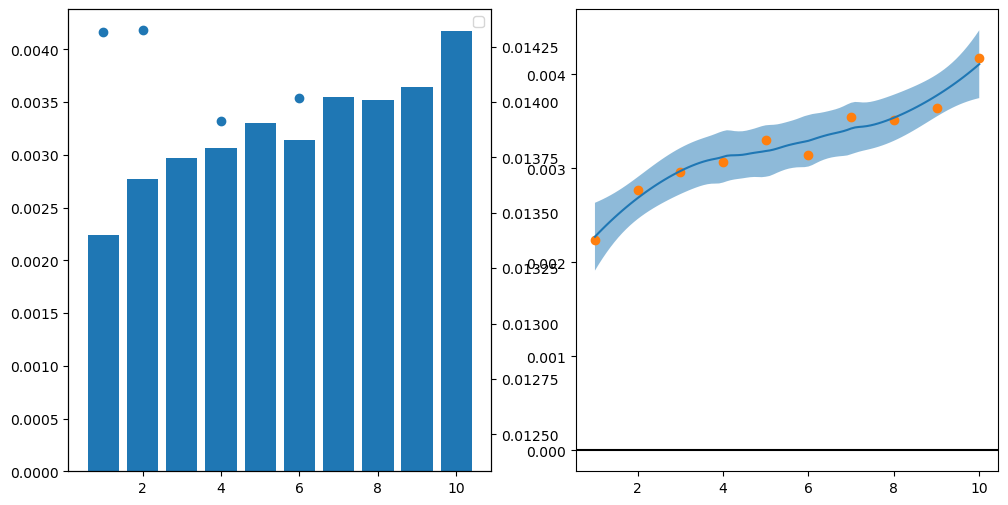

In [240]:
equity_mom_6mo_returns, equity_mom_6mo_spline = get_expected_alpha(bond_data, 'eq_mom_6mo_quantile', plot=True, interpolate=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


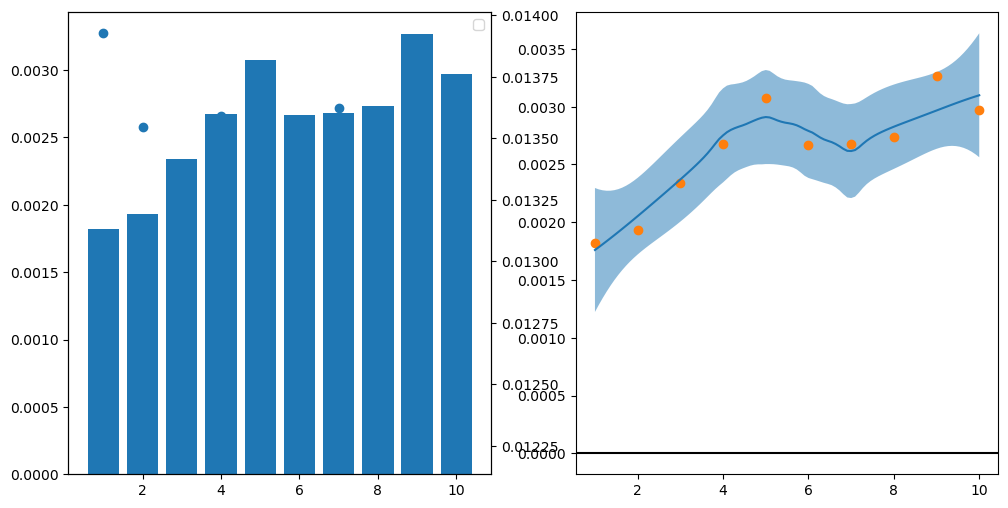

In [241]:
equity_mom_12mo_returns, equity_mom_12mo_spline = get_expected_alpha(bond_data, 'eq_mom_12mo_quantile', plot=True, interpolate=True)

In [243]:
bond_data = quantile_to_alpha_est(bond_data, 'eq_mom_12mo_quantile', 'equity_momentum_signal_value', equity_mom_12mo_spline)

## Conclusing 

In [244]:
bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median,oas_bucket_delta_right,oas_quantile_right,carry_signal_val,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,credit_mom_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_bucket_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_6mo_bucket_delta,eq_mom_6mo_quantile,eq_mom_12mo_bucket_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,2.787959,"""2_A_shortdur""",0.027666,4.676272,0.003748,0.002438,0.001853,8,0.005916,0.000801,0.001853,8,0.505634,0.505634,null,NaN,NaN,NaN,NaN,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,2.363495,"""2_A_shortdur""",0.018979,3.207915,0.002571,0.009157,0.000939,7,0.005916,0.000801,0.000939,7,0.313199,0.313199,0.005302,NaN,NaN,NaN,NaN,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN,null,null,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,2.400071,"""2_A_shortdur""",0.017051,2.882135,0.00231,-0.003401,0.000514,7,0.005916,0.000801,0.000514,7,0.313199,0.313199,0.00289,NaN,NaN,NaN,NaN,null,null,null,null,null,0.006591,0.000514,null,null,null,null,NaN,NaN,null,null,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,2.380807,"""2_A_shortdur""",0.017731,2.996963,0.002402,-0.000117,0.000918,7,0.005916,0.000801,0.000918,7,0.313199,0.313199,-0.000224,NaN,NaN,NaN,NaN,null,null,null,null,null,0.006529,0.000918,null,null,null,null,NaN,NaN,null,null,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,2.1584,"""2_A_shortdur""",0.014568,2.462358,0.001973,0.00001,0.001135,7,0.005916,0.000801,0.001135,7,0.313199,0.313199,0.002127,NaN,NaN,NaN,NaN,null,null,null,null,null,0.005614,0.001135,null,null,null,null,NaN,NaN,

In [245]:
bond_data.null_count() / bond_data.shape[0]

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median,oas_bucket_delta_right,oas_quantile_right,carry_signal_val,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,credit_mom_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_bucket_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_6mo_bucket_delta,eq_mom_6mo_quantile,eq_mom_12mo_bucket_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.175076,0.177607,0.177607,0.175076,0.178273,0.178273,0.180866,0.0,0.00627,0.10033,0.006107,0.0,0.0,0.098822,0.098822,0.0,0.000307,0.106946,0.0,0.069995,0.109154,0.482933,0.06722,0.0,0.0,0.031014,0.031014,0.031014,0.031014,0.031014,0.14938,0.098822,0.031014,0.0,…,0.006115,0.0,0.006115,0.006115,0.006115,0.180646,0.098822,0.098822,0.0,0.0,0.098822,0.098822,0.098822,0.098822,0.002751,0.0,0.12745,0.0,0.136746,0.256976,0.256976,0.310773,0.310773,0.310773,0.000016,0.098822,0.318886,0.318886,0.318886,0.318886,0.0,0.0,0.129526,0.129526,0.174027,0.174027,0.174027


In [246]:
bond_data.write_parquet('../../data/final_data/data_with_signals.pq', compression='zstd', compression_level=10)

# Fama-Macbeth Regression

In [ ]:
def fama_macbeth_bsic(df, yvar: str = 'exretnc_dur_t+1', xvars: list[str] = None, rolling_period: str = '2y', min_periods: int = 8):
    if xvars is None:
        raise Exception('specify xvars')
    
    regressors = [pl.col(var) for var in xvars]
    
    df = df.sort(['cusip', 'date'])
    cols = ['date', 'cusip', yvar]
    
    betas = df.select(*cols, *xvars).rolling('date', period=rolling_period, group_by='cusip').agg(
        pl.when(pl.col('date').len() >= min_periods)
        .then(pl.col(yvar).least_squares.ols(*regressors, add_intercept=True, mode='coefficients', null_policy='drop', solve_method='svd')),
        pl.col('exretnc_dur_t+1').mean().alias('expected_excess_return'),
    )
    
    gammas = betas.unnest('coefficients').group_by('date').agg(
        pl.col('expected_excess_return').least_squares.ols(*regressors, mode='coefficients', null_policy='drop', solve_method='svd')
    )
    
    return gammas

In [ ]:
bond_data.head()

In [ ]:
# oas_quantiles.select('residual_return_t+1', 'oas_bucket_delta', 'cusip').with_columns(
#     pl.col('residual_return_t+1').least_squares.ols(pl.col('oas_bucket_delta'), add_intercept=True, mode="coefficients", null_policy='drop', solve_method='svd').over('cusip')
# ).head()
# dataframe con le date sulla y e i betas per ogni data
signal = 'oas_quantile'
coefficients = oas_quantiles.sort(['cusip', 'date']).select('date', signal, 'cusip', 'exretnc_dur_t+1').rolling('date', period='2y', group_by='cusip').agg(
    pl.when(pl.col('date').len() >= 8)
    .then(pl.col('exretnc_dur_t+1').least_squares.ols(pl.col(signal).cast(pl.Float64), add_intercept=True, mode='coefficients', null_policy='drop', solve_method='svd')),
    pl.col('date').alias('dates'),
    pl.col('date').len().alias('n_dates'),
    pl.col('exretnc_dur_t+1').last(),
    pl.col('exretnc_dur_t+1').alias('list_of_returns'),
)

In [ ]:
coefficients.unnest('coefficients')

In [ ]:
# regredire per ogni data il ritorno di ogni bond vs i fattori

gammas = coefficients.unnest('coefficients').group_by('date').agg(
    pl.col('exretnc_dur_t+1').least_squares.ols(pl.col(signal), mode='coefficients', null_policy='drop', solve_method='svd')
)

In [ ]:
gammas.select('date').n_unique()

In [ ]:
gammas.shape

In [ ]:
gammas = gammas.unnest('coefficients')

In [ ]:
gammas.sort('date').tail(10)

In [ ]:
gammas.sort('date').tail(10)

In [ ]:
gammas.select(pl.col('oas').ewm_mean(span=12))

In [ ]:
X = gammas[0]['betas'].to_numpy()[0]
X = X[~np.isnan(X)]

(1 / (X.T @ X)) * X.T   

In [ ]:
rets.shape

In [ ]:

rets

In [ ]:
example = gammas[0]
# gammas[0].select('betas', 'returns_list').plot(x='betas', y='returns_list')
rets = example['returns_list'].to_numpy().reshape(1,-1)[0][0]
betas = example['betas'].to_numpy().reshape(1,-1)[0][0] 

# sol = np.linalg.lstsq(rets.reshape(-1,1), betas.reshape(-1,1))
# print(sol)

plt.scatter(betas, rets)

In [ ]:
# oas_quantiles.sort('date').select('date', 'residual_return_t+1', 'oas_bucket_delta', 'cusip').with_columns(
#     pl.col('residual_return_t+1').least_squares.rolling_ols(pl.col('oas_bucket_delta'), window_size=252*2, min_periods=126, mode='coefficients', null_policy='drop', ).over(['date', 'cusip'])
# )

coefficients = oas_quantiles.sort('date').select('date', 'residual_return_t+1', 'oas_bucket_delta', 'cusip').select(
    pl.col('residual_return_t+1').least_squares.rolling_ols(pl.col('oas_bucket_delta'), window_size=252*2, min_periods=126, mode='coefficients', null_policy='drop' ).over('cusip'),
    pl.col('cusip'),
    pl.col('date')
)

coefficients.tail()

In [ ]:
coefficients.filter(pl.col('cusip') == "00077QAG5")

In [ ]:
# regress excess return dei bond sui betas cross-sectionally


In [ ]:
coefficients = oas_quantiles.select('date', 'cusip', pl.col('residual_return_t+1').least_squares.ols(pl.col('oas_bucket_delta'), add_intercept=True, mode='coefficients', null_policy='drop', solve_method='svd').over('cusip')).unnest('coefficients')

coefficients.head()

In [ ]:
coefficients.filter(pl.col('cusip') == "00077QAG5").select('oas_bucket_delta')

In [ ]:
oas_quantiles.head()

In [ ]:
regression_data = oas_quantiles.select('date', 'cusip', 'exretnc_t+1', 'oas_quantile')
mkt_returns = regression_data.group_by('date').agg(pl.col('exretnc_t+1').mean().alias('mkt_return'))
regression_data = regression_data.join(
    mkt_returns,
    how='left',
    on='date'
)

regression_data.head()

In [ ]:
datevar = 'date'
yvar = 'exretnc_t+1'
xvar = ['oas_quantile', 'mkt_return']

all_cols = [datevar, yvar, *xvar]
regression_data_pandas = regression_data.select(all_cols).to_pandas().dropna()

regression_data_pandas.head()

In [ ]:
regression_data_pandas.dtypes

In [ ]:
regression_data_pandas.isna().sum()

In [ ]:
fm_regression_results = fama_macbeth.fama_macbeth(regression_data_pandas, t=datevar, yvar=yvar, xvar=xvar)
fama_macbeth.fm_summary(fm_regression_results, pvalues=True)

In [ ]:
fm_regression_results

In [ ]:
fm_regression_results.rolling(12).mean().plot(y='oas_quantile')